# Script used to perform regression, trying to predict the number of attaccks per state, per year.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./part/DF1sthypTOT')

In [3]:
df.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Density,cnt
0,604.5970,51.276,AFG,1960,32.328512,4.000000e+07,739462.0,8255331.0,551.1210,2.252607e+10,13.891572,0.0
1,160.4806,42.240,ALB,1960,62.254366,6.200000e+07,493982.0,1114818.0,151.0588,2.252607e+10,55.962154,0.0
2,373.1320,49.671,DZA,1960,46.135122,1.451501e+09,3394205.0,7730687.0,323.2800,2.252607e+10,4.670910,0.0
3,565.4100,54.423,AGO,1960,32.984829,1.451501e+09,550013.0,4720831.0,500.8860,2.252607e+10,4.227837,0.0
4,275.5520,32.920,ATG,1960,61.782732,1.451501e+09,21684.0,32997.0,244.9240,2.252607e+10,123.433409,0.0


In [4]:
del df['CountryCode']

In [5]:
df.dtypes

SP.DYN.AMRT.MA    float64
SP.DYN.CBRT.IN    float64
Year                int64
SP.DYN.LE00.IN    float64
MS.MIL.MPRT.KD    float64
SP.URB.TOTL       float64
SP.RUR.TOTL       float64
SP.DYN.AMRT.FE    float64
MilitaryExp       float64
Density           float64
cnt               float64
dtype: object

In [6]:
df.describe()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Density,cnt
count,9675.000000,9675.000000,9675.000000,9675.000000,9.675000e+03,9.675000e+03,9.675000e+03,9675.000000,9.675000e+03,9675.000000,9675.000000
mean,270.397297,30.040825,1986.390698,63.051208,8.126313e+08,1.151509e+07,1.518205e+07,199.607566,1.143548e+10,218.366585,12.366408
std,117.642358,13.020843,15.461280,11.333782,6.941853e+08,3.798078e+07,7.352284e+07,123.317763,2.374492e+10,1079.839746,74.534341
min,63.413000,6.900000,1960.000000,19.265512,0.000000e+00,6.627000e+03,0.000000e+00,29.171200,0.000000e+00,0.025899,0.000000
25%,182.181000,18.100000,1973.000000,54.847293,5.100000e+07,4.038695e+05,5.039915e+05,103.424500,1.425978e+08,15.926800,0.000000
50%,251.514000,30.063000,1986.000000,66.024927,9.780000e+08,1.994928e+06,2.519806e+06,159.363000,2.672286e+09,49.687727,0.000000
75%,341.427000,41.978500,2000.000000,71.670195,1.451501e+09,6.918278e+06,7.815200e+06,280.066500,2.252607e+10,117.831373,1.000000
max,921.630000,57.637000,2013.000000,83.831707,5.566000e+09,7.216918e+08,8.701360e+08,799.382000,6.980000e+11,20287.714286,2852.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7418be080>,
      dtype=object)

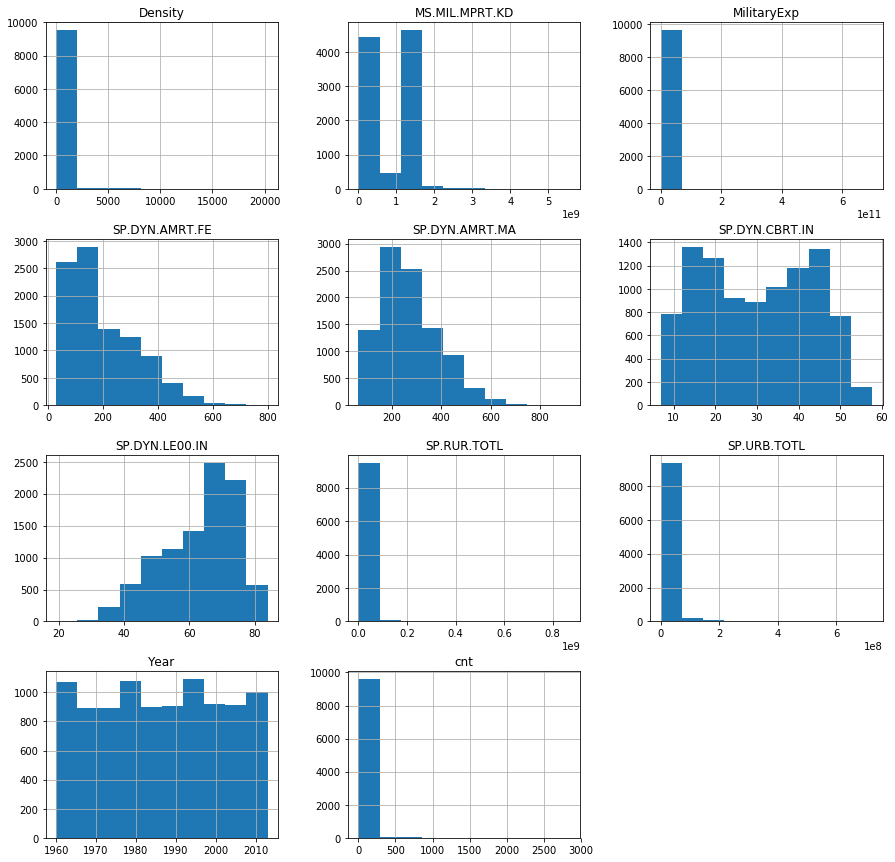

In [7]:
df.hist(figsize=(15,15))

In [8]:
df_std = df 

print('Shape of the df: ', df_std.shape)
print('Number of cnt = 0: ', df_std[df_std['cnt'] == 0].shape)

Shape of the df:  (9675, 11)
Number of cnt = 0:  (6719, 11)


#### We had a lot of values of cnt equal to zero. So we decided to delete all of them, focusing more on the other values of cnt.

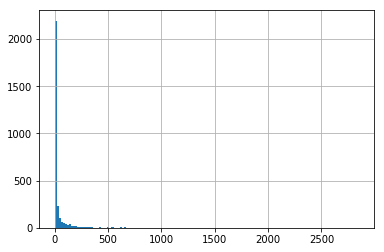

In [9]:
df_std = df_std[df_std['cnt'] > 0]
df_std['cnt'].hist(bins=150)

In [10]:
print('Shape of the df: ', df_std.shape)

Shape of the df:  (2956, 11)


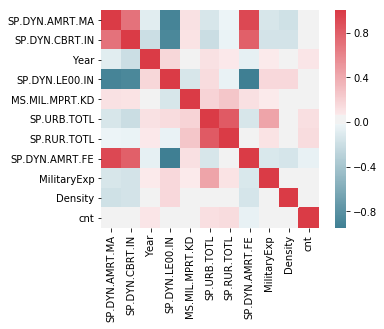

In [11]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [12]:
del df_std['SP.RUR.TOTL']
del df_std['SP.DYN.AMRT.FE']
del df_std['SP.DYN.AMRT.MA']
del df_std['SP.DYN.LE00.IN']

#we deleted them because of collinearity.


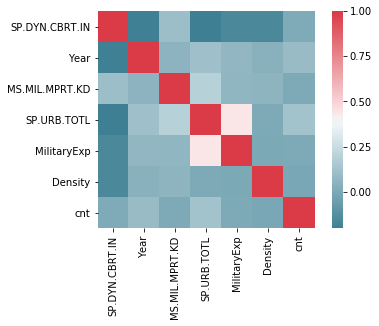

In [13]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [14]:
from sklearn.model_selection import train_test_split

feature_matrix = df_std.loc[:, df_std.columns != 'cnt']
target_vector = df_std.cnt

x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

In [15]:
x_train.shape

(2364, 6)

In [16]:
x_test.shape

(592, 6)

We performed the scaling, using the mean-variance scaling.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

x_train = pd.DataFrame(scale(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scale(x_test), index=x_test.index, columns=x_test.columns)
model=LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)

/home/manuelz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/home/manuelz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/manuelz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """
/home/manuelz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
y_pred_train = model.predict(x_train)

In [19]:
y_pred_test = model.predict(x_test)

In [20]:
from sklearn import metrics

R2_base = metrics.r2_score(y_train, y_pred_train, sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, y_pred_test, sample_weight=None, multioutput='uniform_average')

print("R2 on train: ", R2_base)
print("R2 on test: ", R2)

R2 on train:  0.03557442582935899
R2 on test:  0.002796856764215594


In [21]:
coefficients = pd.Series(model.coef_, index=x_train.columns)
print('Coefficients: ')
print(coefficients)

Coefficients: 
SP.DYN.CBRT.IN     8.045030
Year              12.821568
MS.MIL.MPRT.KD    -4.730831
SP.URB.TOTL       23.951299
MilitaryExp       -8.972070
Density            0.334226
dtype: float64


The results using the regression are so bad, so we tried with a polynomial model.

## Polynomial models applying k-Fold CV and Ridge regularization

In [22]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures as pol
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from statistics import mean 
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=5, shuffle=True, random_state=2) # we are setting 7 folds
feature_matrix=df_std.loc[:, df_std.columns != 'cnt']
target_vector=df_std['cnt']
MSE_tr, MSE_te = [], []
R2_tr, R2_te = [], []
kMSE_tr, kMSE_te = [],  []
kR2_tr, kR2_te = [], []
degrees = [1,2,3,4] # list of different degrees of freedom
for degree in degrees: # cycle which applies the different degrees of freedom
    for train_index, test_index in kf.split(feature_matrix): # cycle that performs KCV on a certain polynomial model
        x_train, x_test = feature_matrix.iloc[train_index], feature_matrix.iloc[test_index]
        y_train, y_test = target_vector.iloc[train_index], target_vector.iloc[test_index]

        x_train = pd.DataFrame(scale(x_train), index=x_train.index, columns=x_train.columns) # standardization
        #y_train = pd.DataFrame(scale(y_train), index=y_train.index).to_numpy() # standardization
        x_test = pd.DataFrame(scale(x_test), index=x_test.index, columns=x_test.columns) # standardization
        #y_test = pd.DataFrame(scale(y_test), index=y_test.index).to_numpy() # standardization

        model = make_pipeline(pol(degree), RidgeCV(alphas=(0.01,1.0,100), cv=4))
        x = model.fit(x_train, y_train.ravel())
        y_pred_on_training=model.predict(x_train)
        y_pred=model.predict(x_test)
        MSE_tr.append(metrics.mean_squared_error(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average'))
        MSE_te.append(metrics.mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
        R2_tr.append(metrics.r2_score(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average'))
        R2_te.append(metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
    kMSE_tr.append(mean(MSE_tr))
    kMSE_te.append(mean(MSE_te))
    kR2_tr.append(mean(R2_tr))
    kR2_te.append(mean(R2_te))
    MSE_tr = []
    MSE_te = []
    R2_tr = []
    R2_te = []
print('kMSE on training, from degree 1 to 4:\n', kMSE_tr)
print('\nkMSE on testing, from degree 1 to 4:\n', kMSE_te)
print('\nkR2 on training, from degree 1 to 4:\n', kR2_tr)
print('\nkR2 on testing, from degree 1 to 4:\n', kR2_te)

kMSE on training, from degree 1 to 4:
 [16530.19415385628, 15210.015010014366, 13449.248032636378, 11800.03392401253]

kMSE on testing, from degree 1 to 4:
 [16608.962963161237, 15434.609486753461, 14865.400094852397, 79510.36832201568]

kR2 on training, from degree 1 to 4:
 [0.03005673752226201, 0.10762117444191568, 0.21059341640316034, 0.30699815096137895]

kR2 on testing, from degree 1 to 4:
 [0.022606158474562023, 0.09411260802471547, 0.12653256696658916, -3.9057117941035187]


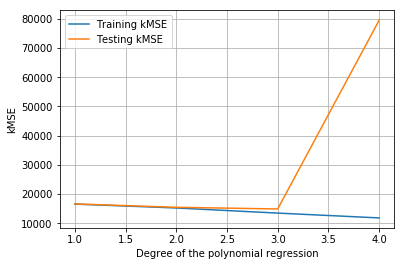

In [23]:
plt.plot(degrees, kMSE_tr, label='Training kMSE')
plt.plot(degrees, kMSE_te, label='Testing kMSE')
plt.xlabel('Degree of the polynomial regression')
plt.ylabel('kMSE')
plt.legend()
plt.grid()

plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import yellowbrick
from yellowbrick.regressor import ResidualsPlot

model = make_pipeline(pol(2), RidgeCV(alphas=(0.01,1.0,100), cv=4))

# Instantiate the linear model and visualizer

visualizer = ResidualsPlot(model)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

ModuleNotFoundError: No module named 'yellowbrick'

The best model was the polynomial with grade 3, resulting in a R2train = 0,30 and a R2test = 0,25. The results are still bad, so we decided to re-formulate the problem, passing to a classification problem.

In [25]:
df_class = df_std.rename(columns={'cnt':'conto'})

#### We are going to divide the data in 3 groups. 

Low number of attacks: 0 < cnt < 3

Medium number of attacks: 3 <= cnt < 15

High number of attacks: cnt >= 15

The splitting was made considering the fact that each cathegory had to be a good amount of sample.

In [26]:
df_class.groupby(by='conto').aggregate({'conto':'count'})

df_class['conto'] = df_class['conto'].apply(lambda x: 0 if (x > 0 and x < 3) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -1 if (x >= 3 and x < 15) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -2 if (x >= 15) else x)

df_class['conto'] = df_class['conto'].apply(lambda x: 1 if (x == -1) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: 2 if (x == -2) else x)

df_class = df_class.rename(columns={'conto':'cnt'})

df_class

,SP.DYN.CBRT.IN,Year,MS.MIL.MPRT.KD,SP.URB.TOTL,MilitaryExp,Density,cnt
1795,22.759,1970,2.530000e+08,18909951.0,4.457139e+08,8.664263,2.0
1798,20.600,1970,2.400000e+08,10664094.0,1.277360e+09,1.627064,0.0
1806,14.700,1970,5.280000e+08,9061057.0,7.477551e+08,316.285017,0.0
1810,42.261,1970,2.000000e+06,1792217.0,1.678714e+07,4.101453,0.0
1813,35.214,1970,2.190000e+08,53662830.0,1.026234e+09,11.276180,1.0
1821,17.400,1970,6.110000e+08,16132459.0,1.889158e+09,2.135674,0.0
1826,37.506,1970,4.000000e+06,12093958.0,1.626625e+08,19.370463,0.0
1836,41.750,1970,1.000000e+06,1810657.0,3.590000e+07,92.409481,0.0
1838,40.130,1970,1.807000e+09,14437563.0,1.092499e+09,34.758200,0.0
1843,48.075,1970,8.900000e+07,2440280.0,3.454000e+07,25.210113,1.0


Here we can see that each class has a good amount of samples.

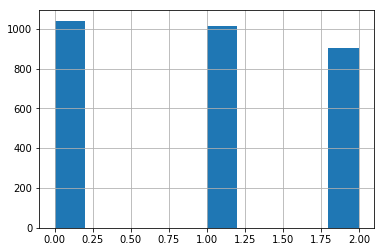

In [27]:
df_class.cnt.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb73e36a160>,
      dtype=object)

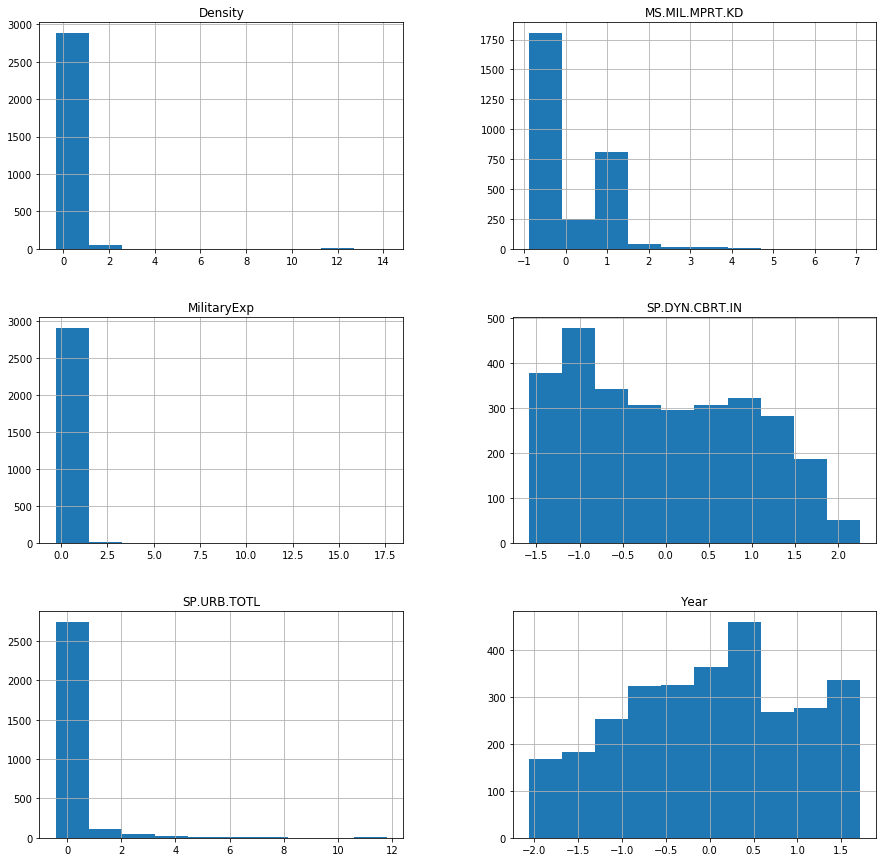

In [28]:
from sklearn.preprocessing import scale

feature_matrix=df_class.loc[:, df_std.columns != 'cnt']
target_vector=df_class['cnt']
feature_matrix = pd.DataFrame(scale(feature_matrix), index=feature_matrix.index, columns=feature_matrix.columns) # standardization
feature_matrix.hist(figsize=(15,15))



In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

We first try with multinomial logistic regression

In [30]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True,random_state=1, max_iter=10000, multi_class='multinomial',solver ='newton-cg').fit(x_train, y_train)
clf.predict(x_train)
print(clf.score(x_train,y_train))

clf.predict(x_test)
print(clf.score(x_test,y_test))

0.4407783417935702
0.44932432432432434


After we try with multi-layer perceptron

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(random_state=1, max_iter=600)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
print('train accuracy: ', accuracy_score(y_train, y_pred_train))

y_pred_test = clf.predict(x_test)
print('test accuracy: ', accuracy_score(y_test, y_pred_test))


train accuracy:  0.6129441624365483
test accuracy:  0.5793918918918919


The results are quite better than the regression case.

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred_train)

array([[517, 216,  85],
       [277, 398, 144],
       [ 78, 115, 534]])

In [33]:
confusion_matrix(y_test, y_pred_test)

array([[136,  66,  20],
       [ 73,  79,  44],
       [ 23,  23, 128]])

##### We try to compare our classifier with a classifier that chooses randomly the class. 2364 training samples, 592 testing samples.

In [34]:
np.random.seed(5)

y_pred_train = np.random.randint(0,3,size=2364)
print('train accuracy: ', accuracy_score(y_train, y_pred_train))

y_pred_test = np.random.randint(0,3,size=592)
print('test accuracy: ', accuracy_score(y_test, y_pred_test))

train accuracy:  0.34052453468697125
test accuracy:  0.3564189189189189


In [39]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_test)

array([[84, 78, 60],
       [61, 70, 65],
       [63, 54, 57]])